### Notebook for IEEE paper: L2 autoencoder for cloud

In [2]:
%matplotlib inline
import os
import sys
import glob
import math
import json
import numpy as np
import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave
# datast mnist
#from tensorflow.keras.datasets.mnist import load_data

In [3]:
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
from sklearn.manifold import TSNE
libdir = '/home/tkurihana/scratch-midway2/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from analysis_lib import get_rand_colors

In [5]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [6]:
import cv2
def get_masks(rpatch_size, channels):

    mask = np.zeros((rpatch_size, rpatch_size), dtype=np.float64)
    cv2.circle(mask, center=(rpatch_size // 2, rpatch_size // 2),
                radius=rpatch_size//2, color=1, thickness=-1)
    mask = np.expand_dims(mask, axis=-1)
    #  multiple dimension
    mask_list = [ mask for i in range(channels)]
    masks = np.concatenate(mask_list, axis=-1)
    return masks

In [7]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        patch = tf.image.resize_images(patch, (height, width))
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

#### Load cloud data

In [12]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2"

In [21]:
#
# raw data
#
tf_datadir="/project2/foster/clouds/data/clouds_laads_rawdecoded_2000_2018"

In [22]:
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [23]:
filelist

['/project2/foster/clouds/data/clouds_laads_rawdecoded_2000_2018/2-10_normed.tfrecord']

H, W, 32

In [49]:
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=32,width=32,channel=6 ))
print("NORMAL END")

OutOfRage --> finish process
NORMAL END


In [50]:
h=w=32
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,h,w, 6) for i in patches_list[0]],
    axis=0)
patches.shape

(2000, 32, 32, 6)

In [51]:
## NaN Mask
width = height = patch_size = 32
nan_mask = get_masks(patch_size, 1).reshape(width,height)
nan_idx = np.where(nan_mask == 0) # (array([x,x,x,x,]) , array([y,y,y,y,y,]))
nan_mask[nan_idx] = np.nan #

H, W, 128

In [24]:
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=128,width=128,channel=6 ))
print("NORMAL END")

OutOfRage --> finish process
NORMAL END


In [25]:
h=w=128
patches128 = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,h,w, 6) for i in patches_list[0]],
    axis=0)
patches128.shape

(2000, 128, 128, 6)

In [31]:
## NaN Mask
width = height = patch_size = 128
nan_mask128 = get_masks(patch_size, 1).reshape(width,height)
nan_idx = np.where(nan_mask128 == 0) # (array([x,x,x,x,]) , array([y,y,y,y,y,]))
nan_mask128[nan_idx] = np.nan #

#### Load model 

In [42]:
model_basedir='/home/tkurihana/rotate_invariant/stepbystep/transform'

In [45]:
expnames = ['66245429','66512447'] # 128, 32

In [46]:
encoder_dict={}
decoder_dict={}
for expname in expnames:
    model_dir=os.path.join(model_basedir, f'output_model/{expname}')
    encoder=load_latest_model(model_dir,'encoder')
    decoder=load_latest_model(model_dir,'decoder')
    encoder_dict[f'{expname}'] = encoder
    decoder_dict[f'{expname}'] = decoder

 Load encoder at 99 epoch
 Load decoder at 99 epoch
 Load encoder at 100 epoch
 Load decoder at 100 epoch


### Image

In [47]:
def compute_test(encoder,decoder, imgs):   
    encoded_imgs = encoder.predict(imgs)    # with rotation
    results = decoder.predict(encoded_imgs)
    return results, encoded_imgs

In [55]:
results_dict = {}
encs_dict = {}
for expname, inputs in zip(expnames, [patches128, patches]):
    _encoder = encoder_dict[f'{expname}']
    _decoder = decoder_dict[f'{expname}']
    result, encs = compute_test(_encoder, _decoder, inputs)
    results_dict[f'{expname}'] = result
    encs_dict[f'{expname}'] = encs

Visualize

In [61]:
sindex = [759,805,1159,1607,1648,1999]

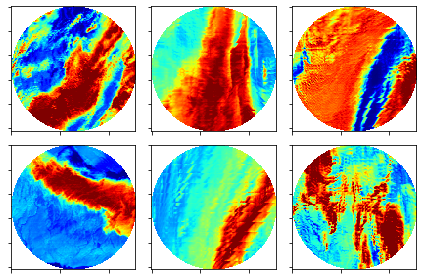

In [66]:
fig = plt.figure()
for idx, i in enumerate(sindex):
    ax = plt.subplot(2,3, idx+1)
    ax.imshow(patches128[i,:,:,0]*nan_mask128, cmap='jet', vmin=0, vmax=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

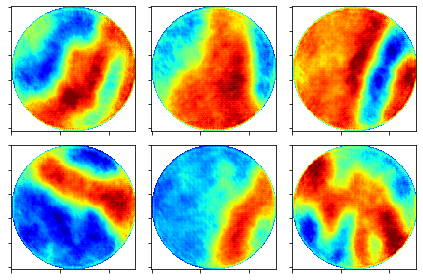

In [67]:
fig = plt.figure()
for idx, i in enumerate(sindex):
    ax = plt.subplot(2,3, idx+1)
    ax.imshow(results_dict['66245429'][i, :,:,0]*nan_mask128, cmap='jet', vmin=0, vmax=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

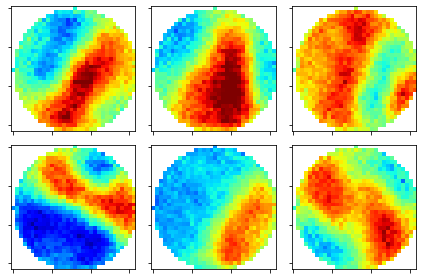

In [68]:
fig = plt.figure()
for idx, i in enumerate(sindex):
    ax = plt.subplot(2,3, idx+1)
    ax.imshow(results_dict['66512447'][i, :,:,0]*nan_mask, cmap='jet', vmin=0, vmax=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

-------------
## Paper figure

In [8]:
def comp_encoding_table(data_basedir='./',expname='0000',all_kernel_list=[], tfname='0-0'):
    """ all_kernel_list [1,2,3,....] include 1 pixel
    """
    model_dir = os.path.join(
        "/home/tkurihana/rotate_invariant/stepbystep/transform/output_model",
        expname
    )
    decoder = load_latest_model(model_dir, mtype='decoder')
    dimgs_list = []
    for kernel in all_kernel_list:
        encoded_imgs = np.load(os.path.join(
                        data_basedir,
                        "encoding_exp-"+str(expname)+"_kernel-"+str(kernel)+"_tfrecord-"+tfname+".npy"
                    )
                )
        decoded_imgs = decoder.predict(encoded_imgs)
        dimgs_list.append(decoded_imgs)
    print("Normal End")
    return np.array(dimgs_list)

In [9]:
## nan mask
def mask_fn(psize=None):
    nan_mask = get_masks(psize, 1).reshape(psize, psize)
    nan_idx = np.where(nan_mask == 0) # (array([x,x,x,x,]) , array([y,y,y,y,y,]))
    nan_mask[nan_idx] = np.nan 
    return nan_mask

In [10]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_rawdecoded_2000_2018"

In [107]:
height = width = 128
## load 
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))
nfiles = 1
#fdx = np.random.randint(0,len(filelist),nfiles)
patches128_list = []
#for ifile in [filelist[i] for i in fdx]:
patches128_list.append(data_extractor_resize_fn(filelist,height=height,width=width,channel=6 ))
print("NORMAL END")
print(len(patches128_list))

## get patch
channel = 6
patches128 = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches128_list[0]],
    axis=0)
print(patches128.shape)

OutOfRage --> finish process
NORMAL END
1
(2000, 128, 128, 6)


In [70]:
edata_basedir = '/home/tkurihana/rotate_invariant/stepbystep/transform/protocol/encodings'

In [71]:
expnames = [67011582,64541244, 'm2_02_global_2000_2018_band28_29_31']

In [72]:
all_kernels = [1]

In [75]:
dimgs_list = []
for expname in expnames:
    dimgs = comp_encoding_table(data_basedir=edata_basedir,expname=str(expname),
                                all_kernel_list=all_kernels, tfname='2-10')
    dimgs_list.append(dimgs)

 Load decoder at 100 epoch
Normal End
 Load decoder at 49 epoch
Normal End
 Load decoder at 100000 epoch



/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Normal End


Visualize now

In [18]:
index = 759

(2000, 128, 128, 6)
(2000, 128, 128, 6)
(2000, 32, 32, 6)


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


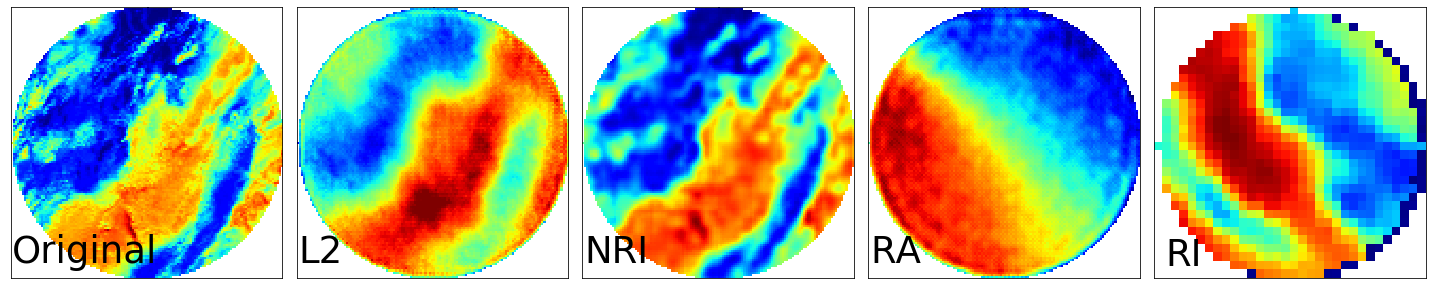

In [112]:
fig = plt.figure(figsize=(20,14))
# original 
ax = plt.subplot(1,5,1)
nmask = mask_fn(128)
ax.imshow(patches128[index, :,:,0]*nmask, cmap='jet')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# L2
ax = plt.subplot(1,5,2)
ax.imshow(results_dict['66245429'][759, :,:,0]*nan_mask128, cmap='jet', vmin=0, vmax=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


tmp_list = [ dimgs_list[-1][0], dimgs_list[-2][0], dimgs_list[0][0] ]
for idx, ipatches in enumerate(tmp_list):
    print(ipatches.shape)
    ax = plt.subplot(1,5,3+idx)
    psize = ipatches[index, :,:,0].shape[0]
    nmask = mask_fn(psize)
    ax.imshow(ipatches[index, :,:,0]*nmask, cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    
    
# add text
yloc = [120]*4+[30]
x=np.linspace(0,1,6)
for idx, label in enumerate([r'Original', r'L2', r'NRI', r"RA", r'RI']):
    ax = plt.subplot(1,5,idx+1)
    ax.text(x[idx],yloc[idx], label, fontsize=37)
    
fig.tight_layout()
#plt.show()
pdf = PdfPages("./fig/all_autoencoders2.pdf")
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()

In [86]:
np.linspace(0,1,6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

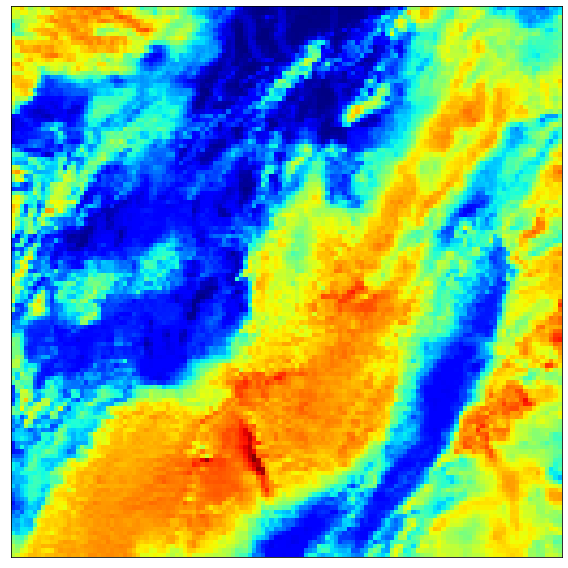

In [30]:
fig = plt.figure(figsize=(8,8))
# original 
ax = plt.subplot(1,1,1)
nmask = mask_fn(128)
ax.imshow(patches128[index, :,:,0], cmap='jet',)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
fig.tight_layout()
#plt.show()
pdf = PdfPages("./fig/original_patch_beforemask.pdf")
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()

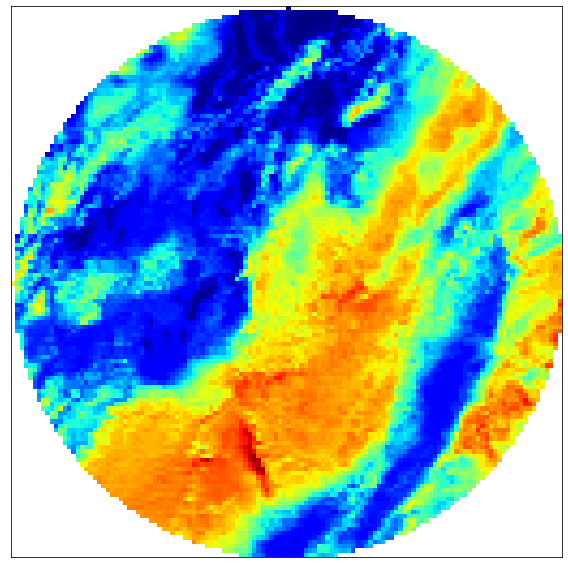

In [32]:
fig = plt.figure(figsize=(8,8))
# original 
ax = plt.subplot(1,1,1)
nmask = mask_fn(128)
ax.imshow(patches128[index, :,:,0]*nan_mask128, cmap='jet',)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
fig.tight_layout()
#plt.show()
pdf = PdfPages("./fig/original_patch_aftermask.pdf")
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()